[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 1024
    # variables        = 6
    chi-square         = 0.00313086
    reduced chi-square = 3.0755e-06
    Akaike info crit   = -12990.6702
    Bayesian info crit = -12961.0814
[[Variables]]
    a0:  0.03954841 +/- 0.00148237 (3.75%) (init = 0.06)
    a1:  107.575249 +/- 0.05138619 (0.05%) (init = 107)
    a2:  1.41413965 +/- 0.04091715 (2.89%) (init = 1)
    a3:  0.00337266 +/- 1.6585e-04 (4.92%) (init = 0)
    a4:  5.6309e-07 +/- 7.4401e-07 (132.13%) (init = 0)
    a5: -1.2362e-09 +/- 7.0192e-10 (56.78%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.968
    C(a3, a4) = -0.867
    C(a3, a5) =  0.746
    C(a0, a2) = -0.570


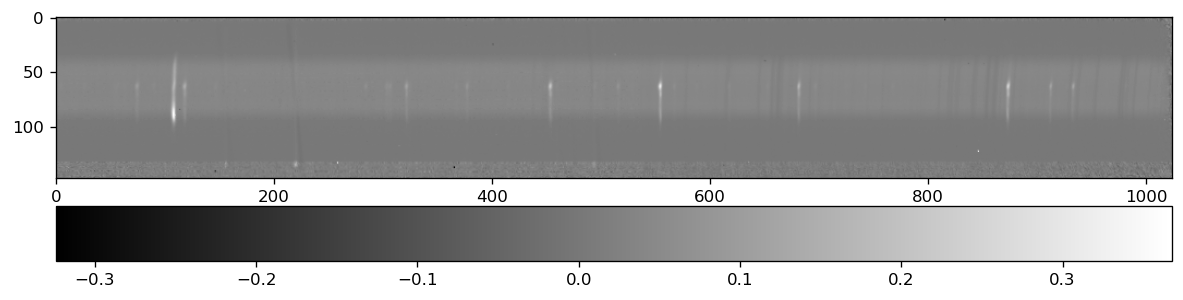

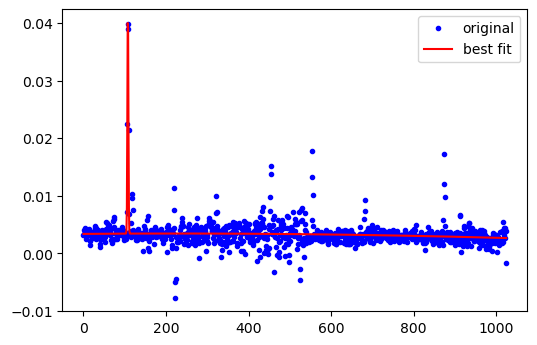

In [1]:
# import packages
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model

# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/order36/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []
for i in range(filesize):
    n = i + 22 # fits index starts from 22
    if n < 100:
        hdu_data = fits.getdata(filepath + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < 112: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 112:
        break
nirspec7_data_array = np.array(nirspec7_data)

# sky 51, 59; object 52 to 58 and the rest
data51 = nirspec7_data_array[51-22] # sky
data59 = nirspec7_data_array[59-22] # sky

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-22], 
                              nirspec7_data_array[33-22], 
                              nirspec7_data_array[34-22], 
                              nirspec7_data_array[35-22], 
                              nirspec7_data_array[36-22], 
                              nirspec7_data_array[37-22], 
                              nirspec7_data_array[38-22], 
                              nirspec7_data_array[39-22], 
                              nirspec7_data_array[40-22], 
                              nirspec7_data_array[41-22],), axis=0)

# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-22], 
                                 nirspec7_data_array[23-22], 
                                 nirspec7_data_array[24-22],
                                 nirspec7_data_array[25-22], 
                                 nirspec7_data_array[26-22], 
                                 nirspec7_data_array[27-22], 
                                 nirspec7_data_array[28-22], 
                                 nirspec7_data_array[29-22], 
                                 nirspec7_data_array[30-22], 
                                 nirspec7_data_array[31-22],), axis=0)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
sky_subtracted = (nirspec7_data_array[61-22] - data59) / (average_flat_field - average_flat_lamp_off)

# show reduced fits
plt.figure(figsize=(12,6), dpi=120)
plt.imshow(sky_subtracted, cmap='gist_gray')
#plt.gca().invert_yaxis()
#plt.xlim(0,200)
#plt.ylim(105,45)
plt.colorbar(orientation='horizontal', pad=0.05)

# load waverange
waverange = fits.open(filepath + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain cropped slit
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))
selected_slit = sky_subtracted[100]
#plt.figure(dpi=100)
#plt.plot(waverange, selected_slit, '.b')

# select certain waverange/pixel
#index = np.where((waverange>2.1216) & (waverange<2.12197))
#index = np.where((pixel>90)*(pixel<140))

# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#def gaussian(x, amp, mu, fwhm): 
#    sig = fwhm / (2*np.sqrt(2*np.log(2)))
#    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# create lmfit model with defined gaussian
h2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(h2_model.param_names))
#print('independent variables: {}'.format(h2_model.independent_vars))
#print('-------------------------------------')

# create parameters and add initial guess
h2_params = h2_model.make_params()
h2_params.add('a0', value=0.06)
h2_params.add('a1', value=107)
h2_params.add('a2', value=1)
h2_params.add('a3', value=0)
h2_params.add('a4', value=0)
h2_params.add('a5', value=0)
#params.add('a0', value=0.02)
#params.add('a1', value=554)
#params.add('a2', value=1)
#params.add('a3', value=0.003)
#params.add('a4', value=0)
#params.add('a5', value=0)

# fit the model
h2_fit = h2_model.fit(selected_slit, h2_params, x=pixel)

# print the result report
print(h2_fit.fit_report())

# plot the result against pixels
# x = pixel; y = selected_slit
plt.figure(dpi=100)
plt.plot(pixel, selected_slit,'b.', label='original')
#plt.plot(x, h2_fit.init_fit, 'k--', label='initial fit')
plt.plot(pixel, h2_fit.best_fit, 'r-', label='best fit')
#plt.xlim(400, 600)
plt.legend(loc='best')
plt.show()

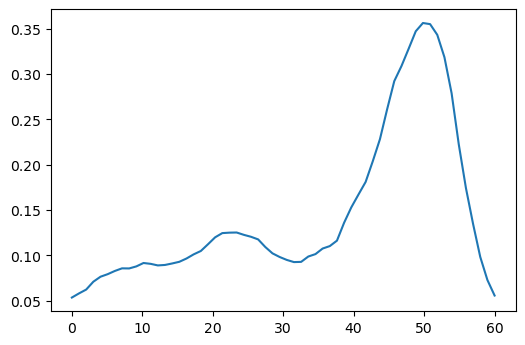

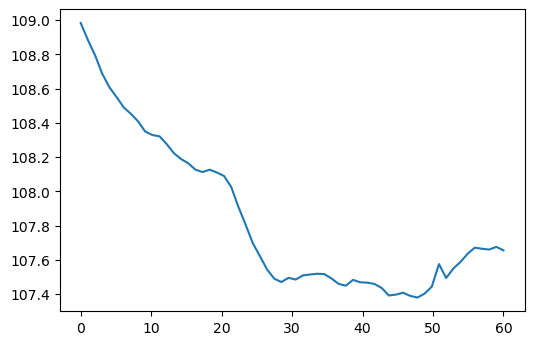

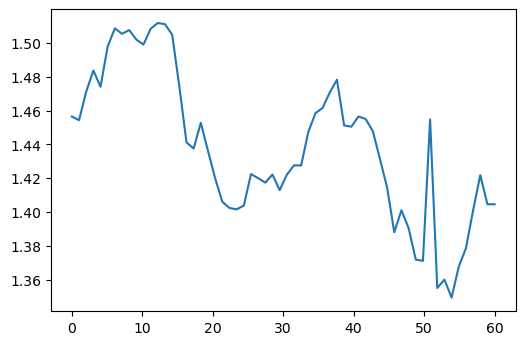

In [3]:
# create lists for all slits
a0_all_slit = []
a1_all_slit = []
a2_all_slit = []
a3_all_slit = []
a4_all_slit = []
a5_all_slit = []

# loop over all slits containing observed emission 
# and obtain fitting parameters of each slit
for i in range(60):
    #y = sky_subtracted[i+40]
    all_slit_result = h2_model.fit(sky_subtracted[i+40], h2_params, x=pixel)
    a0_all_slit.append(all_slit_result.best_values.get('a0'))
    a1_all_slit.append(all_slit_result.best_values.get('a1'))
    a2_all_slit.append(all_slit_result.best_values.get('a2'))
    a3_all_slit.append(all_slit_result.best_values.get('a3'))
    a4_all_slit.append(all_slit_result.best_values.get('a4'))
    a5_all_slit.append(all_slit_result.best_values.get('a5'))
a0_all_slit_array = np.array(a0_all_slit)
a1_all_slit_array = np.array(a1_all_slit)
a2_all_slit_array = np.array(a2_all_slit)
a3_all_slit_array = np.array(a3_all_slit)
a4_all_slit_array = np.array(a4_all_slit)
a5_all_slit_array = np.array(a5_all_slit)

# plot computed fitting parameters against pixels
pixel_all_slit = np.linspace(0, len(a0_all_slit_array), len(a0_all_slit_array))
plt.figure(dpi=100)
plt.plot(pixel_all_slit, a0_all_slit_array)
plt.figure(dpi=100)
plt.plot(pixel_all_slit, a1_all_slit_array)
plt.figure(dpi=100)
plt.plot(pixel_all_slit, a2_all_slit_array)
#plt.figure(dpi=100)
#plt.plot(pixel_all_slit, a3_all_slit_array)
#plt.figure(dpi=100)
#plt.plot(pixel_all_slit, a4_all_slit_array)
#plt.figure(dpi=100)
#plt.plot(pixel_all_slit, a5_all_slit_array)

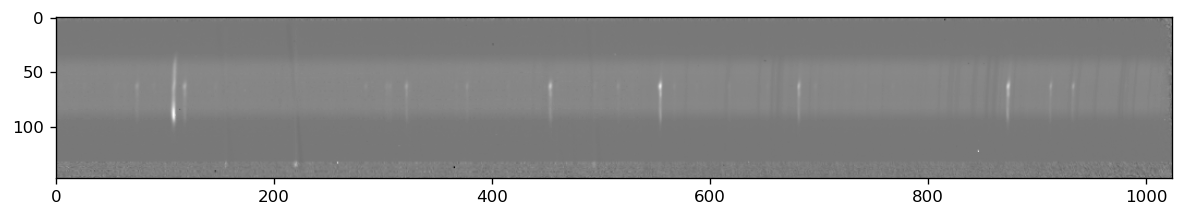

In [4]:
plt.figure(figsize=(12,6), dpi=120)
plt.imshow(sky_subtracted, cmap='gist_gray')
#plt.gca().invert_yaxis()
#plt.xlim(200,400)
#plt.ylim(105,45)

(860.0, 880.0)

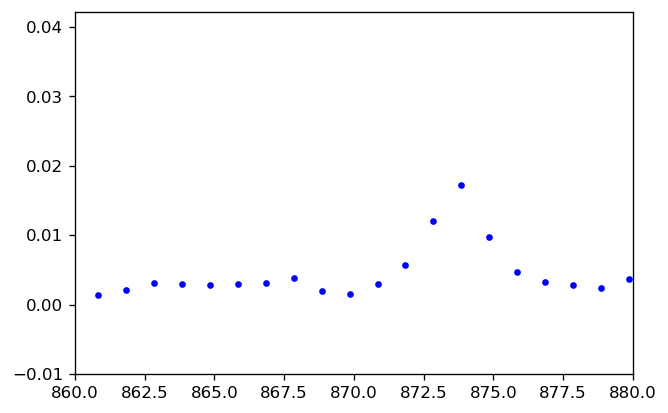

In [8]:
plt.figure(dpi=120)
plt.plot(pixel, selected_slit, '.b')
plt.xlim(860,880)

[[Model]]
    ((((((Model(gaussian_fit, prefix='g1_') + Model(gaussian_fit, prefix='g2_')) + Model(gaussian_fit, prefix='g3_')) + Model(gaussian_fit, prefix='g4_')) + Model(gaussian_fit, prefix='g5_')) + Model(gaussian_fit, prefix='g6_')) + Model(gaussian_fit, prefix='g7_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 486
    # data points      = 1024
    # variables        = 42
    chi-square         = 0.00512151
    reduced chi-square = 5.2154e-06
    Akaike info crit   = -12414.7166
    Bayesian info crit = -12207.5948
##  Warning: uncertainties could not be estimated:
[[Variables]]
    g1_a0:  0.00267924 +/- 0.00204306 (76.26%) (init = 0.005)
    g1_a1:  73.3311825 +/- 0.94377296 (1.29%) (init = 74)
    g1_a2:  1.31881536 +/- 0.77763442 (58.96%) (init = 1)
    g1_a3: -8.03497984 +/-        nan (nan%) (init = 0.003)
    g1_a4: -2.7070e-06 +/- 0.00116338 (42976.97%) (init = 0)
    g1_a5: -3.2643e-10 +/- 1.3684e-07 (41921.28%) (init = 0)
    g2_a0:  0.

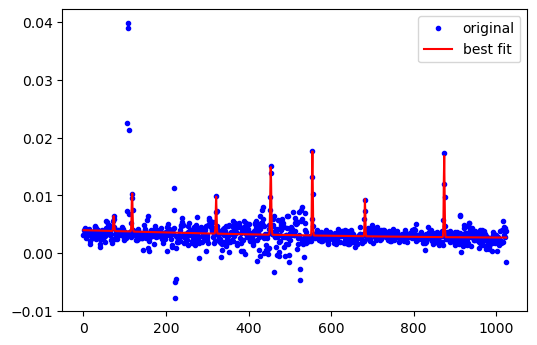

In [6]:
#gmodel = Model(gaussian_fit)
h3p_model = Model(gaussian_fit, prefix='g1_') + Model(gaussian_fit, prefix='g2_') +\
        Model(gaussian_fit, prefix='g3_') + Model(gaussian_fit, prefix='g4_') +\
        Model(gaussian_fit, prefix='g5_') + Model(gaussian_fit, prefix='g6_') + Model(gaussian_fit, prefix='g7_')
#print('parameter names: {}'.format(gmodel.param_names))
#print('independent variables: {}'.format(gmodel.independent_vars))

#params = gmodel.make_params(a0=0.005, a1=74, a2=1, a3=0.1, a4=0, a5=0)
h3p_params = h3p_model.make_params()

# add parameters for 1st fit
h3p_params.add('g1_a0', value=0.005)
h3p_params.add('g1_a1', value=74)
h3p_params.add('g1_a2', value=1)
h3p_params.add('g1_a3', value=0.003)
h3p_params.add('g1_a4', value=0)
h3p_params.add('g1_a5', value=0)

# add parameters for 2nd fit
h3p_params.add('g2_a0', value=0.008)
h3p_params.add('g2_a1', value=117)
h3p_params.add('g2_a2', value=1)
h3p_params.add('g2_a3', value=0.003)
h3p_params.add('g2_a4', value=0)
h3p_params.add('g2_a5', value=0)

# add parameters for 3rd fit
h3p_params.add('g3_a0', value=0.006)
h3p_params.add('g3_a1', value=322)
h3p_params.add('g3_a2', value=1)
h3p_params.add('g3_a3', value=0.003)
h3p_params.add('g3_a4', value=0)
h3p_params.add('g3_a5', value=0)

# add parameters for 4th fit
h3p_params.add('g4_a0', value=0.003)
h3p_params.add('g4_a1', value=452)
h3p_params.add('g4_a2', value=1)
h3p_params.add('g4_a3', value=0.003)
h3p_params.add('g4_a4', value=0)
h3p_params.add('g4_a5', value=0)

# add parameters for 5th fit
h3p_params.add('g5_a0', value=0.02)
h3p_params.add('g5_a1', value=554)
h3p_params.add('g5_a2', value=1)
h3p_params.add('g5_a3', value=0.003)
h3p_params.add('g5_a4', value=0)
h3p_params.add('g5_a5', value=0)

# add parameters for 6th fit
h3p_params.add('g6_a0', value=0.01)
h3p_params.add('g6_a1', value=682)
h3p_params.add('g6_a2', value=1)
h3p_params.add('g6_a3', value=0.003)
h3p_params.add('g6_a4', value=0)
h3p_params.add('g6_a5', value=0)

# add parameters for 7th fit
h3p_params.add('g7_a0', value=0.02)
h3p_params.add('g7_a1', value=874)
h3p_params.add('g7_a2', value=1)
h3p_params.add('g7_a3', value=0.003)
h3p_params.add('g7_a4', value=0)
h3p_params.add('g7_a5', value=0)


h3p_fit = h3p_model.fit(selected_slit, h3p_params, x=pixel)

print(h3p_fit.fit_report())

plt.figure(dpi=100)
plt.plot(pixel, selected_slit,'b.', label='original')
#plt.plot(x, result.init_fit, 'k--', label='initial fit')
plt.plot(pixel, h3p_fit.best_fit, 'r-', label='best fit')
#plt.xlim(250, 350)
plt.legend(loc='best')
plt.show()

# plot more slits
multi_slit = subtracted[45:80,]
multi_pixel = np.linspace(0, 1024, 1024*len(multi_slit))
flattened_slit = np.ravel(multi_slit.T)

plt.figure()
plt.plot(multi_pixel, flattened_slit, '.')

multi_index = np.where((multi_pixel>100)*(multi_pixel<113))

plt.figure()
plt.plot(multi_pixel[multi_index], flattened_slit[multi_index],'.')

for n in range(224): #We use this list to create a list which holds all the data from Order19
    num = n + 76
    if num < 100:
        image_filei = 'D:/Python work/Keck 05Sept06 Data/Keck 05Sept06 Data/05Sep06 Observations/uranus/order19/05sep06_00' + str(num) + '.fits'
        fits.open(image_filei)
        image_datai = fits.getdata(image_filei, ext=0)
        Keck_Data.append(image_datai)
    elif num < 192 and num >= 100:
        image_filei = 'D:/Python work/Keck 05Sept06 Data/Keck 05Sept06 Data/05Sep06 Observations/uranus/order19/05sep06_0' + str(num) + '.fits'
        fits.open(image_filei)
        image_datai = fits.getdata(image_filei, ext=0)
        Keck_Data.append(image_datai)
    elif num >= 192 and num < 196:
        print('Star files')
    elif num >= 196 and num < 296:
        image_filei = 'D:/Python work/Keck 05Sept06 Data/Keck 05Sept06 Data/05Sep06 Observations/uranus/order19/05sep06_0' + str(num) + '.fits'
        fits.open(image_filei)
        image_datai = fits.getdata(image_filei, ext=0)
        Keck_Data.append(image_datai)
    else:
        print('Galaxy files')

notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/order36/')


hdu_list1 = fits.open(filepath + 'jun02s0043_order36.fits', ignore_missing_end=True)
hdu_list2 = fits.open(filepath + 'jun02s0044_order36.fits', ignore_missing_end=True)
hdu_list3 = fits.open(filepath + 'jun02s0045_order36.fits', ignore_missing_end=True)
hdu_list4 = fits.open(filepath + 'jun02s0046_order36.fits', ignore_missing_end=True)

hdu_list5 = fits.open(filepath + 'jun02s0047_order36.fits', ignore_missing_end=True)
hdu_list6 = fits.open(filepath + 'jun02s0048_order36.fits', ignore_missing_end=True)
hdu_list7 = fits.open(filepath + 'jun02s0049_order36.fits', ignore_missing_end=True)
hdu_list8 = fits.open(filepath + 'jun02s0050_order36.fits', ignore_missing_end=True)


data1 = hdu_list1[0].data
data2 = hdu_list2[0].data
data3 = hdu_list3[0].data
data4 = hdu_list4[0].data

data5 = hdu_list5[0].data
data6 = hdu_list6[0].data
data7 = hdu_list7[0].data
data8 = hdu_list8[0].data

sum_A = data1 + data4 + data5 + data8
sum_B = data2 + data3 + data6 + data7

plt.figure(figsize=(8,8))
plt.imshow(sum_B - sum_A)
plt.colorbar()

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

plt.figure(figsize=(10,8))
ax = plt.gca()
im = ax.imshow(data53 - data51)

#### create an axes on the right side of ax. The width of cax will be 5%
#### of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)